In [2]:
import numpy as np
import matplotlib.pyplot as plt
from nnfs.datasets import spiral_data

# Building and training of neural network with backpropagation, gradient descent, learning rate decay, ADAM Optimizer and L1/L2 regularization and dropout layer from scratch

## Load the dataset

[[-0.          0.        ]
 [-0.00206334  0.00988802]
 [ 0.01311929  0.01536248]
 [ 0.00336421  0.03011571]
 [-0.00519856  0.04006821]]
[0 0 0 0 0]


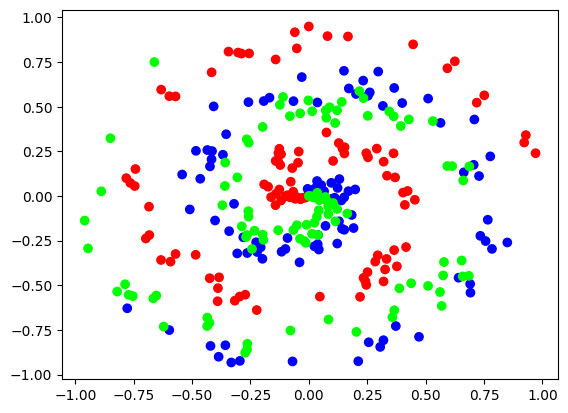

In [18]:
X, y = spiral_data(samples=100, classes=3)

print(X[:5])
print(y[:5])
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="brg")
plt.show()

## Dense Layer

In [4]:
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons, weight_regularizer_l1=0., bias_regularizer_l1=0., weight_regularizer_l2=0., bias_regularizer_l2=0.):
        self.n_inputs = n_inputs
        self.n_neurons = n_neurons
        self.weights = 0.01 * np.random.rand(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        self.weight_regularizer_l1 = weight_regularizer_l1 # lambda
        self.bias_regularizer_l1 = bias_regularizer_l1 # lambda
        self.weight_regularizer_l2 = weight_regularizer_l2 # lambda
        self.bias_regularizer_l2 = bias_regularizer_l2 # lambda

    # forward method
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    # backward method (backpropagation)
    def backward(self, dL_dz):
        # Gradient of loss with respect to weights
        self.dL_dw = np.dot(self.inputs.T, dL_dz)

        # Gradient of loss with respect to biases
        self.dL_db = np.sum(dL_dz, axis=0, keepdims=True)

        # Gradient of loss with respect to inputs
        self.dL_dX = np.dot(dL_dz, self.weights.T)

        # Gradients of regularization
        # L1 weights
        if self.weight_regularizer_l1>0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dL_dw += self.weight_regularizer_l1 * dL1

        # L1 biases
        if self.bias_regularizer_l1>0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dL_db += self.bias_regularizer_l1 * dL1

        # L2 weights
        if self.weight_regularizer_l2>0:
            dL2 = 2 * self.weight_regularizer_l2 * self.weights
            self.dL_dw += dL2

        # L2 biases
        if self.bias_regularizer_l2>0:
            dL2 = 2 * self.bias_regularizer_l2 * self.biases
            self.dL_db += dL2

## Dropout Layer

In [5]:
class Layer_Dropout:
    def __init__(self, dropout_rate=0):
        self.dropout_rate = 1 - dropout_rate

    def forward(self, inputs):
        self.inputs = inputs
        self.binary_mask = np.random.binomial(1, self.dropout_rate, size=inputs.shape) / self.dropout_rate
        self.output = self.inputs * self.binary_mask

    def backward(self, dL_dz):
        self.dL_dX = dL_dz * self.binary_mask

## ReLU Activation

In [6]:
class Activation_ReLU:
    #forward method
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    # backward method (backpropagation)
    def backward(self, dL_da):
        self.dL_dz = dL_da.copy()

        # Gradient calculation
        self.dL_dz[self.inputs <= 0] = 0

## Softmax Activation

In [7]:
class Activation_Softmax:
    def forward(self, final_layer_outputs):
        exp_values = np.exp(final_layer_outputs - np.max(final_layer_outputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities

## Loss function

In [8]:
class Loss:
    def regularization_loss(self, layer):
        regularization_loss = 0

        # L1 Regularization
        if layer.weight_regularizer_l1>0:
            regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))
        if layer.bias_regularizer_l1>0:
            regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))

        # L2 Regularization
        if layer.weight_regularizer_l2 > 0:
            regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights * layer.weights)
        if layer.bias_regularizer_l2 > 0:
            regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases * layer.biases)

        return regularization_loss
    
    def calculate(self, y_pred, y_true):
        neg_log_likelihoods = self.forward(y_pred, y_true)
        avg_loss = np.mean(neg_log_likelihoods)
        return avg_loss

class Loss_CategoricalCrossEntropy(Loss):
    def forward(self, y_pred, y_true):
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)

        if len(y_true.shape) == 1:
            correct_predictions = y_pred_clipped[range(len(y_pred_clipped)), y_true]
            
        if len(y_true.shape) == 2:
            correct_predictions = np.sum(y_pred_clipped*y_true, axis=1)

        neg_log_likelihoods = -np.log(correct_predictions)
        return neg_log_likelihoods

## Combined Softmax Activation and Loss function

In [9]:
class Activation_Softmax_Loss_CategoricalCrossEntropy:
    def __init__(self):
        self.activation_softmax = Activation_Softmax()
        self.loss_function = Loss_CategoricalCrossEntropy()

    # forward method
    def forward(self, final_layer_output, y_true):
        self.activation_softmax.forward(final_layer_output)
        self.softmax_output = self.activation_softmax.output
        self.loss = self.loss_function.calculate(self.softmax_output, y_true)

        return self.loss

    # backward method (backpropagation)
    def backward(self, y_pred, y_true):
        no_of_batches = len(y_pred)
        
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        self.dL_dz = self.softmax_output.copy()

        # Gradient calculation
        self.dL_dz[range(no_of_batches), y_true] -= 1

        # Normalization
        self.dL_dz = self.dL_dz / no_of_batches

# ADAM Optimizer (Mostly used and most important) with decaying learning rate

In [10]:
class Optimizer_ADAM:
    def __init__(self, learning_rate=.001, decay=0, epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay # learning rate decay factor
        self.epsilon = epsilon # To avoid divide by zero
        self.beta_1 = beta_1 # momentum factor
        self.beta_2 = beta_2 # rho: cache memory decay rate
        self.epoch = 0

    def pre_update_params(self):
        # learning rate decay
        self.current_learning_rate = self.learning_rate / (1. + self.decay*self.epoch)

    def update_params(self, layer):
        if not hasattr(layer, "weight_cache"):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)
            
        layer.weight_momentums = self.beta_1*layer.weight_momentums + (1-self.beta_1)*layer.dL_dw
        layer.bias_momentums = self.beta_1*layer.bias_momentums + (1-self.beta_1)*layer.dL_db

        layer.weight_cache = self.beta_2*layer.weight_cache + (1-self.beta_2)*layer.dL_dw**2
        layer.bias_cache = self.beta_2*layer.bias_cache + (1-self.beta_2)*layer.dL_db**2

        layer.weights += -self.current_learning_rate*(layer.weight_momentums/(1-self.beta_1**(self.epoch+1))) /\
                                                     (np.sqrt(layer.weight_cache/(1-self.beta_2**(self.epoch+1))) + self.epsilon)

        layer.biases += -self.current_learning_rate*(layer.bias_momentums/(1-self.beta_1**(self.epoch+1))) /\
                                                    (np.sqrt(layer.bias_cache/(1-self.beta_2**(self.epoch+1))) + self.epsilon)

    def post_update_params(self):
        self.epoch += 1

## Training the neural network

Epoch: 0 Accuracy: 0.360 Loss: 1.099 (data_loss: 1.099 regularization_loss: 0.000) lr: 0.0200000
Epoch: 100 Accuracy: 0.577 Loss: 0.901 (data_loss: 0.879 regularization_loss: 0.022) lr: 0.0199990
Epoch: 200 Accuracy: 0.677 Loss: 0.757 (data_loss: 0.718 regularization_loss: 0.040) lr: 0.0199980
Epoch: 300 Accuracy: 0.680 Loss: 0.729 (data_loss: 0.682 regularization_loss: 0.047) lr: 0.0199970
Epoch: 400 Accuracy: 0.697 Loss: 0.710 (data_loss: 0.659 regularization_loss: 0.051) lr: 0.0199960
Epoch: 500 Accuracy: 0.683 Loss: 0.733 (data_loss: 0.681 regularization_loss: 0.052) lr: 0.0199950
Epoch: 600 Accuracy: 0.700 Loss: 0.695 (data_loss: 0.641 regularization_loss: 0.053) lr: 0.0199940
Epoch: 700 Accuracy: 0.700 Loss: 0.677 (data_loss: 0.623 regularization_loss: 0.054) lr: 0.0199930
Epoch: 800 Accuracy: 0.730 Loss: 0.658 (data_loss: 0.604 regularization_loss: 0.055) lr: 0.0199920
Epoch: 900 Accuracy: 0.693 Loss: 0.706 (data_loss: 0.651 regularization_loss: 0.055) lr: 0.0199910
Epoch: 1000 

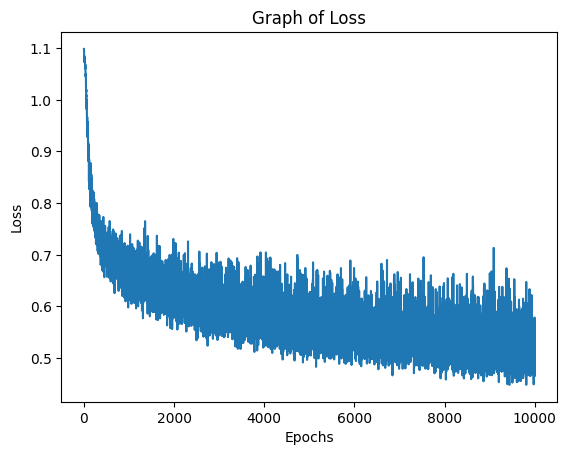

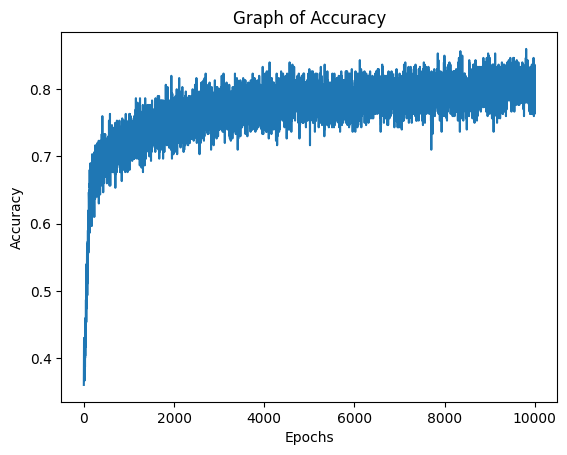

Validation accuracy: 0.7933333333333333 Validation loss: 0.6964097204415739


In [19]:
# Defining the architecture
# dense_layer1 = Layer_Dense(2, 64)
dense_layer1 = Layer_Dense(2, 128, weight_regularizer_l2=5e-4, bias_regularizer_l2=5e-4)
activation_relu = Activation_ReLU()
dropout_layer1 = Layer_Dropout(dropout_rate=0.1)
dense_layer2 = Layer_Dense(128, 3)
softmax_loss = Activation_Softmax_Loss_CategoricalCrossEntropy()

# SGS Optimizer
optimizer_adam = Optimizer_ADAM(learning_rate=0.02, decay=5e-7)

loss_history = []
acc_history = []

for epoch in range(10001):
    # entire forward pass
    dense_layer1.forward(X)
    activation_relu.forward(dense_layer1.output)
    dropout_layer1.forward(activation_relu.output)
    dense_layer2.forward(dropout_layer1.output)
    softmax_loss.forward(final_layer_output=dense_layer2.output, y_true=y)

    data_loss = softmax_loss.loss
    regularization_loss = (
        softmax_loss.loss_function.regularization_loss(dense_layer1) +
        softmax_loss.loss_function.regularization_loss(dense_layer2)
    )
    loss = data_loss + regularization_loss
    loss_history.append(loss)

    predictions = np.argmax(softmax_loss.softmax_output, axis=1)
    accuracy = np.mean(predictions == y)
    acc_history.append(accuracy)

    if epoch % 100 == 0:
        print(f'Epoch: {epoch} Accuracy: {accuracy:.3f} Loss: {loss:.3f} (data_loss: {data_loss:.3f} regularization_loss: {regularization_loss:.3f}) lr: {optimizer_adam.current_learning_rate:.7f}')

    # entire backward pass (backpropagation)
    softmax_loss.backward(softmax_loss.softmax_output, y)
    dense_layer2.backward(dL_dz=softmax_loss.dL_dz)
    dropout_layer1.backward(dL_dz=dense_layer2.dL_dX)
    activation_relu.backward(dL_da=dropout_layer1.dL_dX)
    dense_layer1.backward(dL_dz=activation_relu.dL_dz)

    # Applying optimizer (Gradient descent with decaying learning rate and momentum)
    optimizer_adam.pre_update_params()
    optimizer_adam.update_params(dense_layer1)
    optimizer_adam.update_params(dense_layer2)
    optimizer_adam.post_update_params()

plt.plot(loss_history)
plt.title("Graph of Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

plt.plot(acc_history)
plt.title("Graph of Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

# Testing the neural network on new data
X_test, y_test = spiral_data(samples=100, classes=3)

# forward pass with test data
dense_layer1.forward(X_test)
activation_relu.forward(dense_layer1.output)
dense_layer2.forward(activation_relu.output)
softmax_loss.forward(final_layer_output=dense_layer2.output, y_true=y_test)

loss = softmax_loss.loss
predictions = np.argmax(softmax_loss.softmax_output, axis=1)
accuracy = np.mean(predictions == y)

print(f"Validation accuracy: {accuracy} Validation loss: {loss}")

# Trainig with more sample points

Epoch: 0 Accuracy: 0.338 Loss: 1.099 (data_loss: 1.099 regularization_loss: 0.000) lr: 0.0200000
Epoch: 100 Accuracy: 0.637 Loss: 0.864 (data_loss: 0.828 regularization_loss: 0.037) lr: 0.0199990
Epoch: 200 Accuracy: 0.714 Loss: 0.747 (data_loss: 0.690 regularization_loss: 0.057) lr: 0.0199980
Epoch: 300 Accuracy: 0.745 Loss: 0.686 (data_loss: 0.623 regularization_loss: 0.063) lr: 0.0199970
Epoch: 400 Accuracy: 0.755 Loss: 0.675 (data_loss: 0.610 regularization_loss: 0.065) lr: 0.0199960
Epoch: 500 Accuracy: 0.767 Loss: 0.658 (data_loss: 0.592 regularization_loss: 0.065) lr: 0.0199950
Epoch: 600 Accuracy: 0.782 Loss: 0.638 (data_loss: 0.574 regularization_loss: 0.064) lr: 0.0199940
Epoch: 700 Accuracy: 0.784 Loss: 0.642 (data_loss: 0.580 regularization_loss: 0.062) lr: 0.0199930
Epoch: 800 Accuracy: 0.787 Loss: 0.618 (data_loss: 0.557 regularization_loss: 0.061) lr: 0.0199920
Epoch: 900 Accuracy: 0.790 Loss: 0.609 (data_loss: 0.550 regularization_loss: 0.059) lr: 0.0199910
Epoch: 1000 

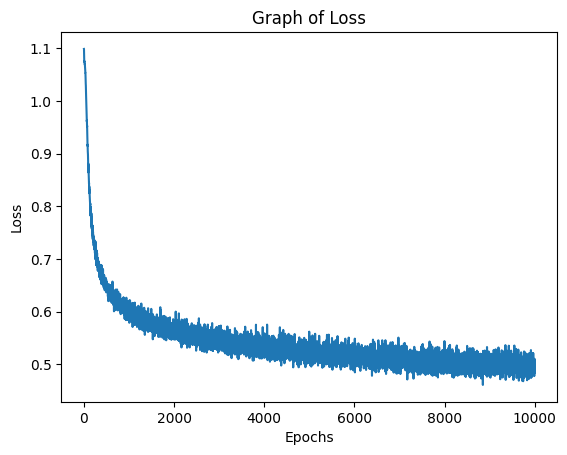

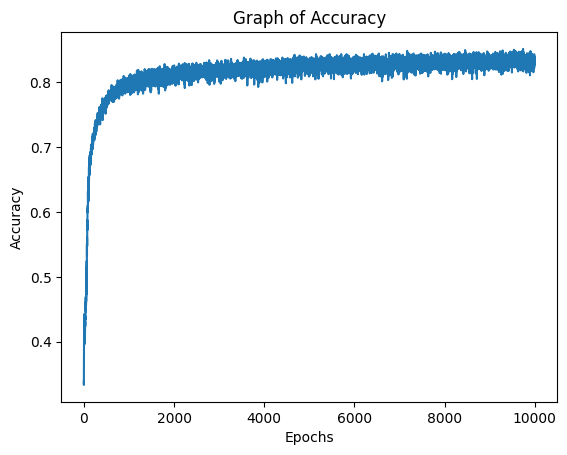

Validation accuracy: 0.8403333333333334 Validation loss: 0.42530029369356875


In [16]:
X, y = spiral_data(samples=1000, classes=3)

# Defining the architecture
# dense_layer1 = Layer_Dense(2, 64)
dense_layer1 = Layer_Dense(2, 128, weight_regularizer_l2=5e-4, bias_regularizer_l2=5e-4)
activation_relu = Activation_ReLU()
dropout_layer1 = Layer_Dropout(dropout_rate=0.05)
dense_layer2 = Layer_Dense(128, 3)
softmax_loss = Activation_Softmax_Loss_CategoricalCrossEntropy()

# SGS Optimizer
optimizer_adam = Optimizer_ADAM(learning_rate=0.02, decay=5e-7)

loss_history = []
acc_history = []

for epoch in range(10001):
    # entire forward pass
    dense_layer1.forward(X)
    activation_relu.forward(dense_layer1.output)
    dropout_layer1.forward(activation_relu.output)
    dense_layer2.forward(dropout_layer1.output)
    softmax_loss.forward(final_layer_output=dense_layer2.output, y_true=y)

    data_loss = softmax_loss.loss
    regularization_loss = (
        softmax_loss.loss_function.regularization_loss(dense_layer1) +
        softmax_loss.loss_function.regularization_loss(dense_layer2)
    )
    loss = data_loss + regularization_loss
    loss_history.append(loss)

    predictions = np.argmax(softmax_loss.softmax_output, axis=1)
    accuracy = np.mean(predictions == y)
    acc_history.append(accuracy)

    if epoch % 100 == 0:
        print(f'Epoch: {epoch} Accuracy: {accuracy:.3f} Loss: {loss:.3f} (data_loss: {data_loss:.3f} regularization_loss: {regularization_loss:.3f}) lr: {optimizer_adam.current_learning_rate:.7f}')

    # entire backward pass (backpropagation)
    softmax_loss.backward(softmax_loss.softmax_output, y)
    dense_layer2.backward(dL_dz=softmax_loss.dL_dz)
    dropout_layer1.backward(dL_dz=dense_layer2.dL_dX)
    activation_relu.backward(dL_da=dropout_layer1.dL_dX)
    dense_layer1.backward(dL_dz=activation_relu.dL_dz)

    # Applying optimizer (Gradient descent with decaying learning rate and momentum)
    optimizer_adam.pre_update_params()
    optimizer_adam.update_params(dense_layer1)
    optimizer_adam.update_params(dense_layer2)
    optimizer_adam.post_update_params()

plt.plot(loss_history)
plt.title("Graph of Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

plt.plot(acc_history)
plt.title("Graph of Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

# Testing the neural network on new data
X_test, y_test = spiral_data(samples=1000, classes=3)

# forward pass with test data
dense_layer1.forward(X_test)
activation_relu.forward(dense_layer1.output)
dense_layer2.forward(activation_relu.output)
softmax_loss.forward(final_layer_output=dense_layer2.output, y_true=y_test)

loss = softmax_loss.loss
predictions = np.argmax(softmax_loss.softmax_output, axis=1)
accuracy = np.mean(predictions == y)

print(f"Validation accuracy: {accuracy} Validation loss: {loss}")